In [1]:
suppressPackageStartupMessages(source("/ahg/regevdata/users/jklugham/projects/HTAPP_MBC/src/init.R"))

Loading combined annotation: annot


### Load data (has been produced using the combine script)

In [ ]:
#all samples
simpleCache(cacheName = "fresh_downsampled_100", 
            cacheDir = cacheDir, 
            cacheSubDir = "combined_seurat", 
            recreate = FALSE,assignToVariable = "cs_all")

::Loading cache::	/ahg/regevdata/projects/HTAPP_MBC//RCache//combined_seurat/fresh_downsampled_100.RData


In [ ]:
#all samples frozen
simpleCache(cacheName = "frozen_TST_downsampled_100",
            cacheDir = cacheDir, 
            cacheSubDir = "combined_seurat", 
            recreate = FALSE,assignToVariable = "cs_all")

### Load selected genes

In [ ]:
sel_genes=fread(paste0(analysisDir,"00_spatial_probes/final_selection_300_V3_topics.tsv"))
candidate_genes=fread(paste0(analysisDir,"00_spatial_probes/candidate_genes_combined_V3_topics.tsv"))

In [ ]:
data_ct_genes=candidate_genes[gene%in%sel_genes$gene&grepl("data_ct",method)]

In [ ]:
data_topics_genes=candidate_genes[gene%in%sel_genes$gene&grepl("topics",method)]

In [ ]:
cell_types=c("Astrocyte","Neurons","Neuroepithelial_cell","Embryonic_stem_cells","iPS_cells","Chondrocytes","Osteoblasts","Smooth_muscle_cells","Epithelial_cells","Endothelial_cells","Fibroblasts","Hepatocytes","Macrophage","Monocyte","NK_cell","T_cells","B_cell")

In [ ]:
cond=as.data.table(cs_all@meta.data[,c("sampleID","labels"),drop=FALSE],keep.rownames = "cellid")
#add new labels column
cond[,labels_simpl:=ifelse(labels%in%cell_types,labels,"other"),]
cond[,labels_simpl:=ifelse(labels%in%c("Astrocyte","Neurons","Neuroepithelial_cell"),"Epithelial_neuro",labels_simpl),]
cond[,labels_simpl:=ifelse(labels%in%c("Embryonic_stem_cells","iPS_cells"),"Epithelial_stem",labels_simpl),]
cond[,labels_simpl:=ifelse(labels%in%c("Chondrocytes","Osteoblasts","Smooth_muscle_cells"),"Mesenchymal",labels_simpl),]
cond[,labels_simpl:=ifelse(grepl("B_cell",labels),"B_cell",labels_simpl),]
cond[,labels_group:=ifelse(grepl("Epithelial",labels_simpl),"Malignant",ifelse(grepl("B_|T_|NK_",labels_simpl),"Lymphocytes",ifelse(grepl("Mono|Macro",labels_simpl),"Mono/Macro",labels_simpl))),]

In [ ]:
cond=merge(cond,unique(sample_sheet[,c("sampleid","site")]),by.x="sampleID",by.y="sampleid",all.x=TRUE)

In [ ]:
#site
cond[,site_simpl:=site,]
cond[,site_simpl:=ifelse(site_simpl%in%c("axilla","left axilla","right axilla","left axillary lymph node"),"lymph node",site_simpl),]
cond[,site_simpl:=ifelse(site_simpl%in%c("left breast"),"breast",site_simpl),]
cond[,site_simpl:=ifelse(site_simpl%in%c("chest wall","left lower abdomen skin punch","left parietal","left peristernal soft tissue mass","right breast skin punch"),"other",site_simpl),]

In [ ]:
cond=data.frame(cond,row.names = which(colnames(cond)=="cellid"))
cs_all=AddMetaData(cs_all,metadata = cond)

In [ ]:
md=as.data.table(cs_all@meta.data,keep.rownames = "cellid")

In [ ]:
cell_order=c("Epithelial_cells","Epithelial_stem","Epithelial_neuro","Fibroblasts","Mesenchymal","Endothelial_cells","Macrophage","Monocyte","T_cells","NK_cell","B_cell","Hepatocytes","other")
type_order=c('Epithelial_cells+','Epithelial_stem+','Epithelial_stem-','Fibroblasts+','Endothelial_cells+','Macrophage+','MonoMacro+','Monocyte+','T_cells+','T_cells-','NK_cell+','B_cell+','Plasma_cell+')

In [ ]:
data_ct_genes[,type:=factor(type,levels=type_order),]

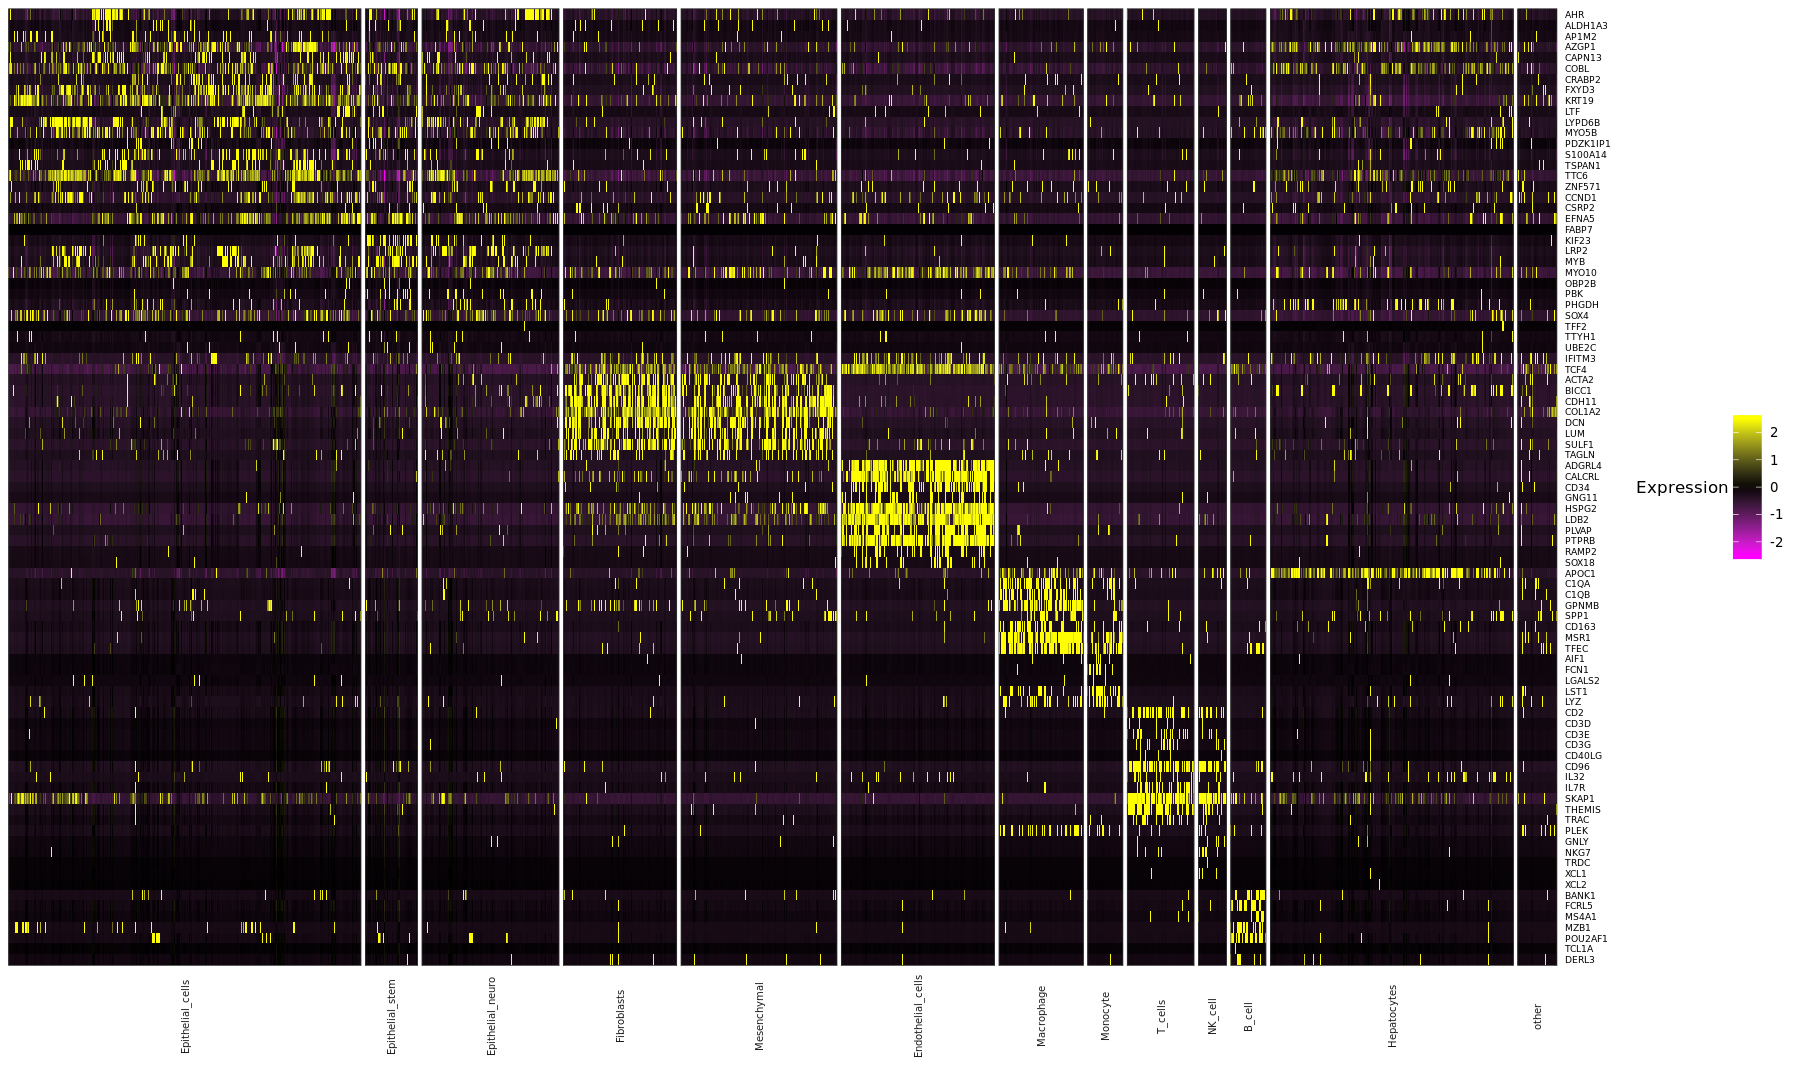

In [24]:
options(repr.plot.width = 15, repr.plot.height = 9)
DoHeatmap(cs_all,group.cex = 6,group.order = cell_order,slim.col.label = TRUE,group.label.rot = TRUE,
          draw.line = TRUE,genes.use = unique(data_ct_genes[order(type)]$gene),group.by = "labels_simpl",cex.row = 5.5,cex.col = 0)

In [25]:
topics_mat=cs_all@scale.data[unique(data_topics_genes[grepl("malignant_t",type)][order(type)]$gene),md[labels_group=="Malignant"]$cellid]

In [26]:
cor=cor(t(topics_mat))

In [27]:
cor[cor==1]=max(cor[cor!=1])

In [28]:
library(pheatmap)

In [29]:
annot=data.frame(data_topics_genes[grepl("malignant_t",type),c("gene","type"),][!duplicated(gene)][,type:=factor(type),],row.names = "gene")

In [30]:
colors=c()
colors[levels(annot$type)]=RColorBrewer::brewer.pal(n = 6,name = "Set2")
colors=list(type=colors)

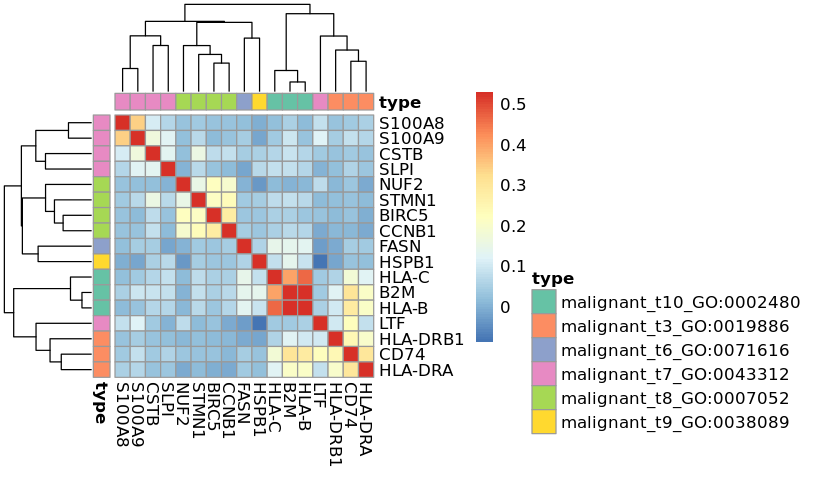

In [31]:
options(repr.plot.width = 7, repr.plot.height = 4)
pheatmap(cor,annotation_col = annot, annotation_row = annot,cluster_rows = T,cluster_cols = T, annotation_colors = colors)

### Program signatures

In [16]:
topic_genes=data_topics_genes[grepl("malignant_t",type),c("gene","type"),]

In [17]:
topic_list=lapply(unique(topic_genes$type),function(x){topic_genes[type==x]$gene})
names(topic_list)=unique(topic_genes$type)
topic_list

$`malignant_t10_GO:0002480`
[1] "B2M"   "HLA-B" "HLA-C"

$`malignant_t8_GO:0007052`
[1] "BIRC5" "CCNB1" "NUF2"  "STMN1"

$`malignant_t3_GO:0019886`
[1] "CD74"     "HLA-DRA"  "HLA-DRB1"

$`malignant_t7_GO:0043312`
[1] "CSTB"   "LTF"    "S100A8" "S100A9" "SLPI"  

$`malignant_t6_GO:0071616`
[1] "FASN"

$`malignant_t9_GO:0038089`
[1] "HSPB1"

In [18]:
cs_all=AddModuleScore(cs_all,topic_list,enrich.name = names(topic_list))
colnames(cs_all@meta.data)[colnames(cs_all@meta.data)%in%paste0(names(topic_list),1:length(names(topic_list)))]=names(topic_list)

In [19]:
md=as.data.table(cs_all@meta.data,keep.rownames = "cellid")

In [20]:
md_mal_topics_long=melt(md[labels_group=="Malignant",c("cellid","site_simpl","labels_simpl",names(topic_list)),with=FALSE],id.vars = c("cellid","site_simpl","labels_simpl"),value.name = "Module score",variable.name = "Program")

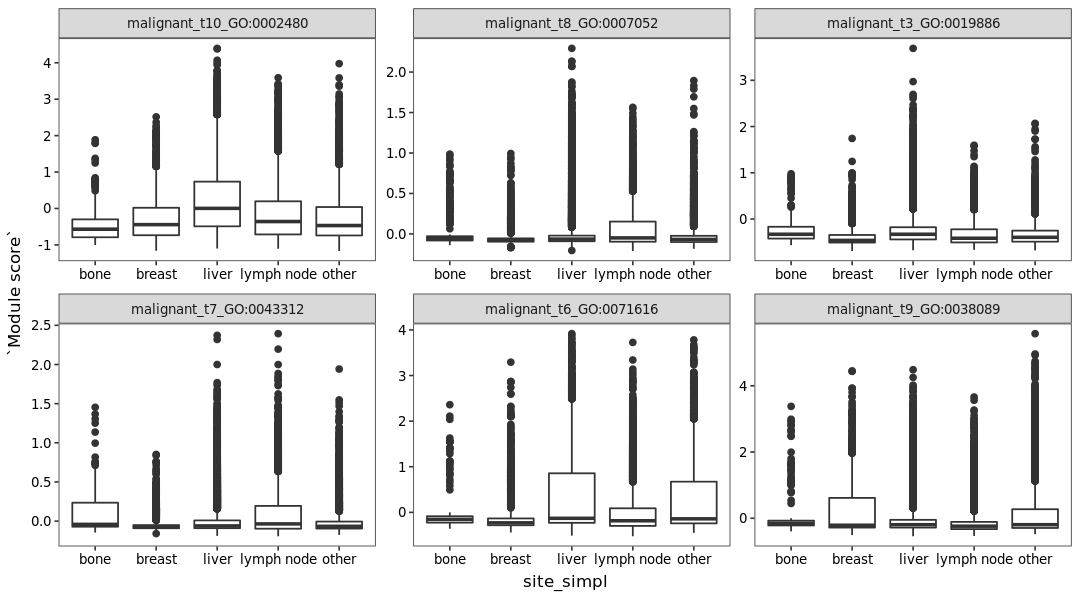

In [21]:
options(repr.plot.width = 9, repr.plot.height = 5)
ggplot(md_mal_topics_long,aes(x=site_simpl,y=`Module score`))+geom_boxplot()+facet_wrap(~Program,scale="free")

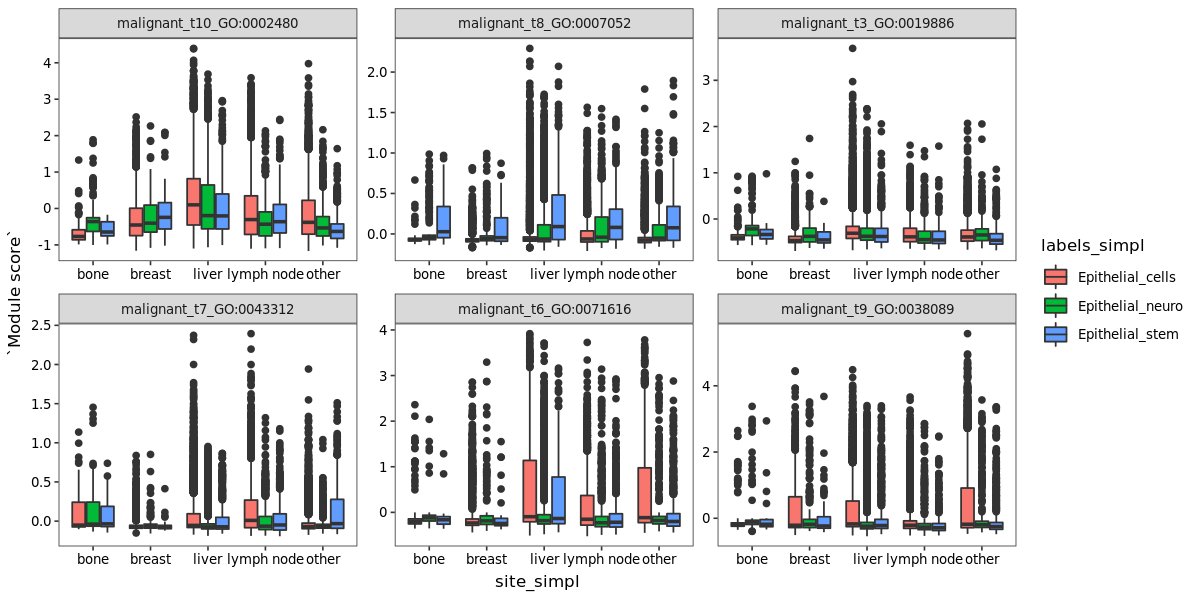

In [23]:
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(md_mal_topics_long,aes(x=site_simpl,y=`Module score`,fill=labels_simpl))+geom_boxplot()+facet_wrap(~Program,scale="free")